# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

In [1]:
# Получаем датасет

Для визуализации изображений используйте функцию:

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import glob
import os
import xml.etree.ElementTree as ET
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import models, transforms

import torch.nn as nn
import torch.nn.functional as F
import torch

from tqdm.notebook import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')


def display_images(paths,titles=None,fontsize=12):
    n=len(paths)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(paths):
        image = Image.open(im)
        ax[i].imshow(image)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

## Создадим DataFrame для удобства и посмотрим данные

In [3]:
SPLIT_RATIO = 0.8
XMLS = "/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/"
IMAGES = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images/"

In [4]:
k = 0
output = []
xml_files = glob.glob("{}/*xml".format(XMLS))
for i, xml_file in enumerate(xml_files):
    tree = ET.parse(xml_file)

    path = os.path.join(IMAGES, tree.findtext("./filename"))
    family = tree.findtext("./object/name")
    basename = os.path.basename(path)
    basename = os.path.splitext(basename)[0]
    class_name = basename[:basename.rfind("_")].lower()

    output.append((path, class_name, family))

output.sort(key=lambda tup : tup[-1])

In [5]:
df = pd.DataFrame(output, columns = ["path", "form", "family"])
df

path  \
0     /kaggle/input/the-oxfordiiit-pet-dataset/image...   
1     /kaggle/input/the-oxfordiiit-pet-dataset/image...   
2     /kaggle/input/the-oxfordiiit-pet-dataset/image...   
3     /kaggle/input/the-oxfordiiit-pet-dataset/image...   
4     /kaggle/input/the-oxfordiiit-pet-dataset/image...   
...                                                 ...   
3681  /kaggle/input/the-oxfordiiit-pet-dataset/image...   
3682  /kaggle/input/the-oxfordiiit-pet-dataset/image...   
3683  /kaggle/input/the-oxfordiiit-pet-dataset/image...   
3684  /kaggle/input/the-oxfordiiit-pet-dataset/image...   
3685  /kaggle/input/the-oxfordiiit-pet-dataset/image...   

                            form family  
0                         birman    cat  
1              british_shorthair    cat  
2                         birman    cat  
3              british_shorthair    cat  
4                   egyptian_mau    cat  
...                          ...    ...  
3681  staffordshire_bull_terrier    dog  
3682                   chihuahua    dog  
3683                  leonberger    dog  
3684                newfoundland    dog  
3685                   shiba_inu    dog  

[3686 rows x 3 columns]

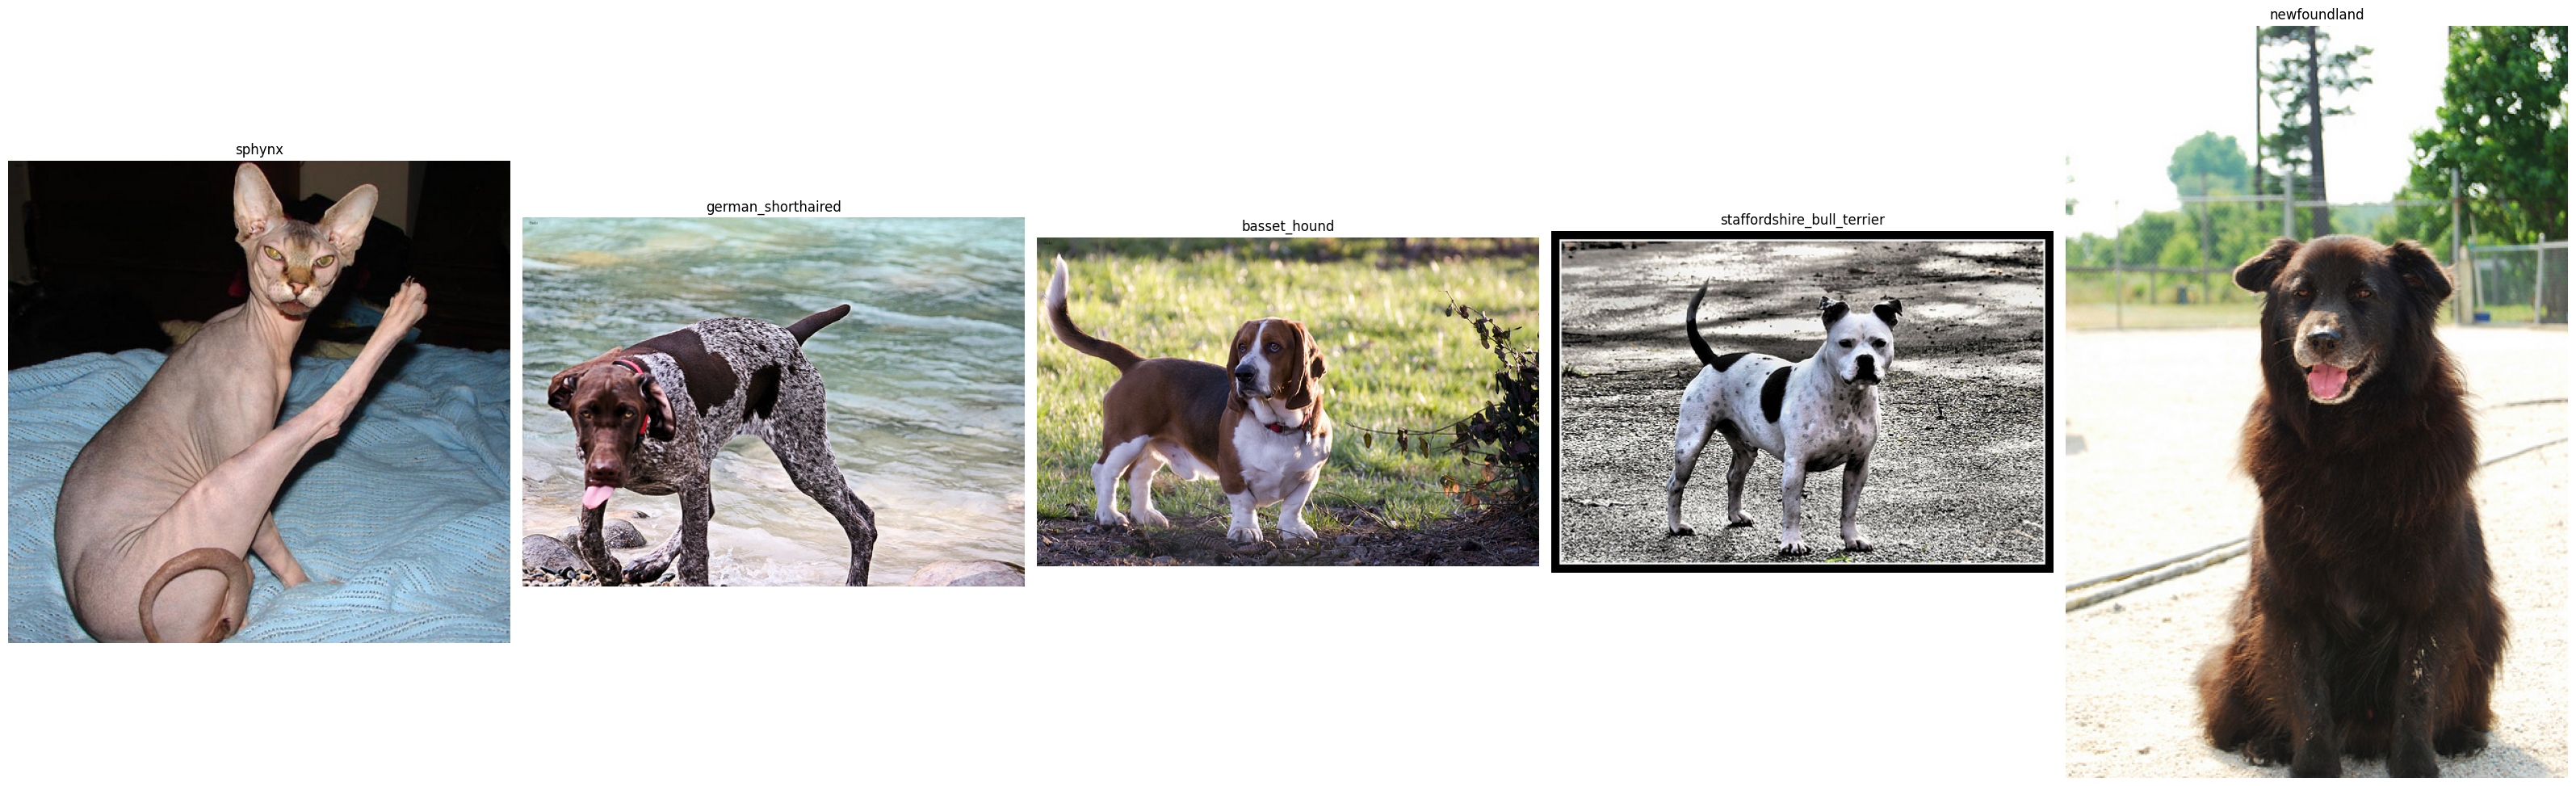

In [6]:
N = 5
samples_images = df.sample(N)
display_images(list(samples_images["path"]), list(samples_images["form"]))

## Создадим класс Dataset для работы с картинками и аугментации

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [8]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224


class DogCatDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, df, target, mode):
        super().__init__()

        self.files = list(df["path"])
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = list(df[target])
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == "train":
            augmentations = transforms.RandomChoice([
                                   transforms.Compose([
                                       transforms.Resize(size=313, max_size=333),
                                       transforms.CenterCrop(size=300),
                                       transforms.RandomCrop(250)
                                       ]),
                                   transforms.RandomRotation(degrees=(-33, 33)),
                                   transforms.RandomHorizontalFlip(p=1),
                                   ])
            transform = transforms.Compose([
                                    augmentations,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

        if self.files[index][-3:] == "png":
            x = Image.open(self.files[index])
            x = x.convert("RGB")
        else:
            x = self.load_sample(self.files[index])
        x = x.convert("RGB")
        x = transform(x)
        if self.mode == 'test':
            return x, self.files[index]
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y, self.files[index]

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

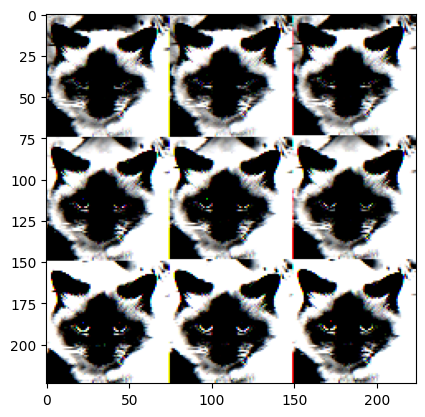

In [9]:
images = DogCatDataset(df, target = "family", mode = "train")
plt.imshow(np.reshape(images[2][0].numpy(), (224, 224, 3)))

## Функции для обучения

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, sheduler = None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for images, labels, _ in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(-1)
        running_loss += loss.item()*images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += images.size(0)
    if sheduler is not None:
        sheduler.step()
    loss_train = running_loss / processed_data
    acc_train = running_corrects.cpu().numpy() / processed_data
    
    return loss_train, acc_train

In [11]:
def val_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for images, labels, _ in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(-1)

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += images.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    return val_loss, val_acc

In [12]:
def train(model, train_loader, val_loader, criterion = None, optimizer = None, epochs = 20, sheduler = None):
    if optimizer is None:
          optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
          criterion = nn.CrossEntropyLoss()

    loss = {"train":[], "val":[]}
    accuracy = {"train":[], "val": []}
    
    best_accuracy = 0.0
    
    best_model_wts = model.state_dict()

    log_template = "\nEpoch {ep:03d}\t train_loss: {t_loss:0.4f}\t \
    val_loss {v_loss:0.4f}\t train_acc {t_acc:0.4f}\t val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            loss_train, accuracy_train = train_epoch(model, train_loader, criterion, optimizer, sheduler)
            loss["train"].append(loss_train)
            accuracy["train"].append(accuracy_train)

            loss_val, accuracy_val = val_epoch(model, val_loader, criterion)
            loss["val"].append(loss_val)
            accuracy["val"].append(accuracy_val)

            if accuracy_val > best_accuracy:
                best_accuracy = accuracy_val
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss_train,\
                                               v_loss=loss_val, t_acc=accuracy_train, v_acc=accuracy_val))
            

    print("best val Acc: {:4f}".format(best_accuracy))
    model.load_state_dict(best_model_wts)
            
    return model, loss, accuracy

## Многоклассовая классификация

## Загрузим модели для сравнения

In [13]:
model_vgg19 = models.vgg19(pretrained=True)
model_vgg16 = models.vgg16(pretrained=True)
model_resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 169MB/s] 
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]  
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s] 


Посмотрим архитектуру и количество параметров

In [14]:
num_params = sum(p.numel() for p in model_vgg16.parameters())
print(model_vgg16)
print("\n Count parameters:", num_params)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
num_params = sum(p.numel() for p in model_vgg19.parameters())
print(model_vgg19)
print("\n Count parameters:", num_params)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
num_params = sum(p.numel() for p in model_resnet.parameters())
print(model_resnet)
print("\n Count parameters:", num_params)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

На самом деле все они помещаются в память, предоставляемую kaggle(кроме линейных слоев после conv), и поэтому будем обучать их на нашем датасете, но при малых lr

In [17]:
df_train, df_val = train_test_split(df, test_size = 0.15, stratify=df["form"])
print(df.shape)
print(df_train.shape)
print(df_val.shape)

train_data = DogCatDataset(df_train, target = "form", mode = "train")
val_data = DogCatDataset(df_val, target = "form", mode = "val")


train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 128)

(3686, 3)
(3133, 3)
(553, 3)


In [18]:
n_classes = df["form"].unique().size

model_vgg16.classifier = nn.Linear(25088, n_classes, bias=True)

model_vgg16.to(DEVICE)

optimizer = torch.optim.Adam(params=[
        {"params": model_vgg16.classifier.parameters()},
        {"params": model_vgg16.features.parameters(), "lr": 1e-5 },
        {"params": model_vgg16.avgpool.parameters(), "lr": 1e-5}
    ],
    lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_vgg16, loss_vgg16, accuracy_vgg16 = train(model_vgg16, train_loader, val_loader, epochs = 10, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001	 train_loss: 1.4481	     val_loss 0.5415	 train_acc 0.6192	 val_acc 0.8373

Epoch 002	 train_loss: 0.2572	     val_loss 0.4332	 train_acc 0.9170	 val_acc 0.8662

Epoch 003	 train_loss: 0.1462	     val_loss 0.3809	 train_acc 0.9521	 val_acc 0.8861

Epoch 004	 train_loss: 0.0785	     val_loss 0.3588	 train_acc 0.9754	 val_acc 0.8915

Epoch 005	 train_loss: 0.0643	     val_loss 0.3599	 train_acc 0.9796	 val_acc 0.8897

Epoch 006	 train_loss: 0.0560	     val_loss 0.3543	 train_acc 0.9818	 val_acc 0.8951

Epoch 007	 train_loss: 0.0401	     val_loss 0.3538	 train_acc 0.9930	 val_acc 0.8951

Epoch 008	 train_loss: 0.0451	     val_loss 0.3531	 train_acc 0.9891	 val_acc 0.8951

Epoch 009	 train_loss: 0.0434	     val_loss 0.3527	 train_acc 0.9872	 val_acc 0.8933

Epoch 010	 train_loss: 0.0460	     val_loss 0.3526	 train_acc 0.9869	 val_acc 0.8933
best val Acc: 0.895118


Очистим память, для обучения следующей модели

In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

12845

In [20]:
n_classes = df["form"].unique().size


model_vgg19.classifier = nn.Linear(25088, n_classes, bias=True)

model_vgg19.to(DEVICE)

optimizer = torch.optim.Adam(params=[
        {"params": model_vgg19.classifier.parameters()},
        {"params": model_vgg19.features.parameters(), "lr": 1e-5 },
        {"params": model_vgg19.avgpool.parameters(), "lr": 1e-5}
    ],
    lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_vgg19, loss_vgg19, accuracy_vgg19 = train(model_vgg19, train_loader, val_loader, epochs = 10, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001	 train_loss: 1.4198	     val_loss 0.4994	 train_acc 0.6339	 val_acc 0.8481

Epoch 002	 train_loss: 0.2612	     val_loss 0.3488	 train_acc 0.9138	 val_acc 0.8861

Epoch 003	 train_loss: 0.1232	     val_loss 0.2911	 train_acc 0.9591	 val_acc 0.9005

Epoch 004	 train_loss: 0.0699	     val_loss 0.2819	 train_acc 0.9815	 val_acc 0.9078

Epoch 005	 train_loss: 0.0645	     val_loss 0.2773	 train_acc 0.9802	 val_acc 0.9078

Epoch 006	 train_loss: 0.0504	     val_loss 0.2773	 train_acc 0.9844	 val_acc 0.9060

Epoch 007	 train_loss: 0.0426	     val_loss 0.2774	 train_acc 0.9869	 val_acc 0.9060

Epoch 008	 train_loss: 0.0445	     val_loss 0.2768	 train_acc 0.9869	 val_acc 0.9060

Epoch 009	 train_loss: 0.0434	     val_loss 0.2757	 train_acc 0.9879	 val_acc 0.9060

Epoch 010	 train_loss: 0.0505	     val_loss 0.2757	 train_acc 0.9853	 val_acc 0.9060
best val Acc: 0.907776


In [21]:
torch.cuda.empty_cache()
gc.collect()

18

In [22]:
n_classes = df["form"].unique().size

#for param in param_no_grad:
#    param.requires_grad = False

model_resnet.fc = nn.Linear(2048, n_classes, bias=True)

model_resnet.to(DEVICE)

optimizer = torch.optim.Adam(params=[
    {"params": model_resnet.fc.parameters()},
    {"params": model_resnet.conv1.parameters(), "lr": 1e-5 },
    {"params": model_resnet.avgpool.parameters(), "lr": 1e-5},
    {"params": model_resnet.bn1.parameters(), "lr": 1e-5},
    {"params": model_resnet.relu.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer1.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer2.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer3.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer4.parameters(), "lr": 1e-5}
    ],
    lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_resnet, loss_resnet, accuracy_resnet = train(model_resnet, train_loader, val_loader, epochs = 10, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001	 train_loss: 2.0837	     val_loss 0.6727	 train_acc 0.5669	 val_acc 0.8354

Epoch 002	 train_loss: 0.4993	     val_loss 0.2952	 train_acc 0.9151	 val_acc 0.9367

Epoch 003	 train_loss: 0.2662	     val_loss 0.2400	 train_acc 0.9368	 val_acc 0.9385

Epoch 004	 train_loss: 0.1963	     val_loss 0.2180	 train_acc 0.9585	 val_acc 0.9458

Epoch 005	 train_loss: 0.1896	     val_loss 0.2129	 train_acc 0.9588	 val_acc 0.9476

Epoch 006	 train_loss: 0.1817	     val_loss 0.2119	 train_acc 0.9604	 val_acc 0.9458

Epoch 007	 train_loss: 0.1720	     val_loss 0.2106	 train_acc 0.9617	 val_acc 0.9476

Epoch 008	 train_loss: 0.1792	     val_loss 0.2086	 train_acc 0.9620	 val_acc 0.9476

Epoch 009	 train_loss: 0.1770	     val_loss 0.2078	 train_acc 0.9588	 val_acc 0.9476

Epoch 010	 train_loss: 0.1771	     val_loss 0.2088	 train_acc 0.9646	 val_acc 0.9512
best val Acc: 0.951175


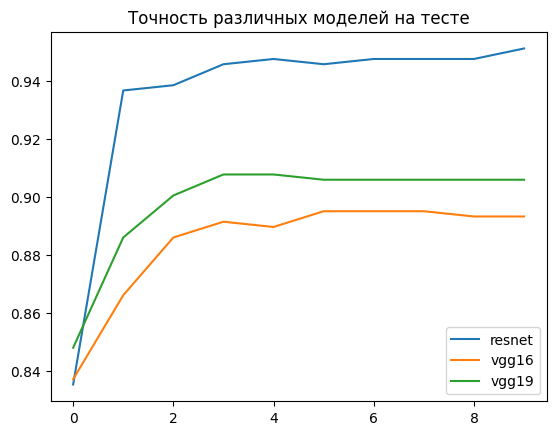

In [23]:
plt.plot(accuracy_resnet["val"], label = "resnet")
plt.plot(accuracy_vgg16["val"], label = "vgg16")
plt.plot(accuracy_vgg19["val"], label = "vgg19")

plt.title("Точность различных моделей на тесте")
plt.legend()

Лучше всего показала себя модель resnet

Построим матрицу ошибок

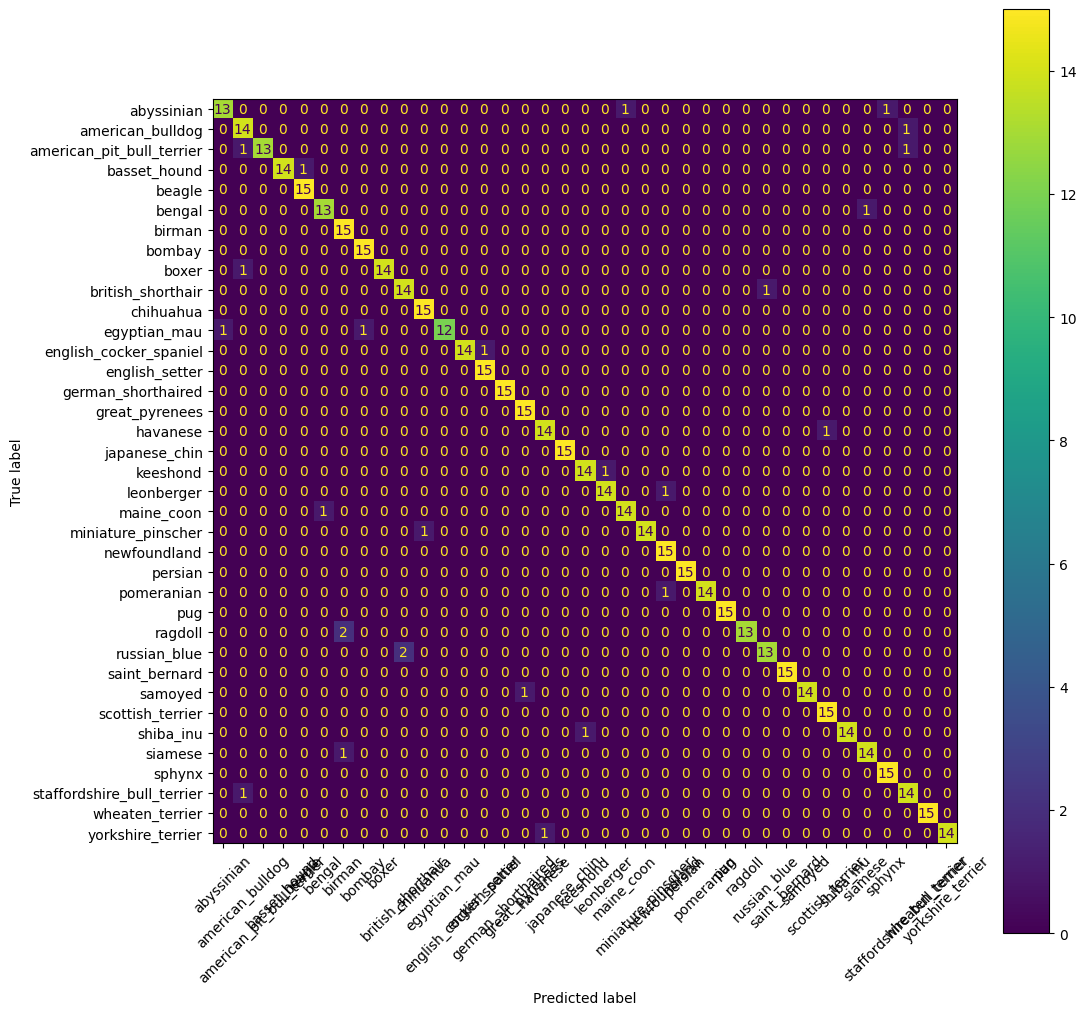

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def flatten(xss):
    return [x for xs in xss for x in xs]

y_test = []
predictions = []
misclassified_data = []
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

model_resnet.to("cpu")
for data, target, path in val_loader:
    data = data
    output = model_resnet(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred = pred.view(data.size(0))
    
    y_test.append(target.cpu().numpy())
    predictions.append(pred.cpu().numpy())
    
    misclassified_indices = (pred.cpu() != target).nonzero()
    for idx in misclassified_indices:
        misclassified_data.append([path[idx], label_encoder.classes_[pred[idx].item()]])

# misclassified_data содержит данные, которые были неправильно классифицированы
y_test = flatten(y_test)
predictions = flatten(predictions)

cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize = (12, 12))
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(ax = ax)
plt.xticks(rotation = 45)
plt.show()

Посчитаем accuracy top-k

In [25]:
def accuracy_topk(output, target, topk=(1,)):
    """Вычисляет точность top-k для прогнозов output и целевых меток target."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        acc_list = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            acc_list.append(correct_k.mul_(100.0 / batch_size))
        return acc_list

model_resnet.to('cpu')
top3_acc = []
top5_acc = []
for data, target, path in val_loader:
    data = data
    output = model_resnet(data)
    top3, top5 = accuracy_topk(output.cpu(), target, topk=(3, 5))
    top3_acc.append(top3.item())
    top5_acc.append(top5.item())

print('Top-3 Accuracy:', np.mean(top3_acc), '%')
print('Top-5 Accuracy:',  np.mean(top5_acc), '%')

Top-3 Accuracy: 99.6875 %
Top-5 Accuracy: 100.0 %


## Интерпретация модели или же на что смотрит модель при ответе

In [26]:
!pip -q install grad-cam

In [29]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def run_grad_cam_on_image(model, target_layer, targets_for_gradcam, reshape_transform, input_tensor, input_image, method=GradCAM):
    with method(model=model,
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:

        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
dict_num_class = {name: i for i, name in enumerate(label_encoder.classes_)}
dict_num_class

{'abyssinian': 0,
 'american_bulldog': 1,
 'american_pit_bull_terrier': 2,
 'basset_hound': 3,
 'beagle': 4,
 'bengal': 5,
 'birman': 6,
 'bombay': 7,
 'boxer': 8,
 'british_shorthair': 9,
 'chihuahua': 10,
 'egyptian_mau': 11,
 'english_cocker_spaniel': 12,
 'english_setter': 13,
 'german_shorthaired': 14,
 'great_pyrenees': 15,
 'havanese': 16,
 'japanese_chin': 17,
 'keeshond': 18,
 'leonberger': 19,
 'maine_coon': 20,
 'miniature_pinscher': 21,
 'newfoundland': 22,
 'persian': 23,
 'pomeranian': 24,
 'pug': 25,
 'ragdoll': 26,
 'russian_blue': 27,
 'saint_bernard': 28,
 'samoyed': 29,
 'scottish_terrier': 30,
 'shiba_inu': 31,
 'siamese': 32,
 'sphynx': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [31]:
classes = ["shiba_inu", "chihuahua", "sphynx", "persian", "american_bulldog", "british_shorthair"]

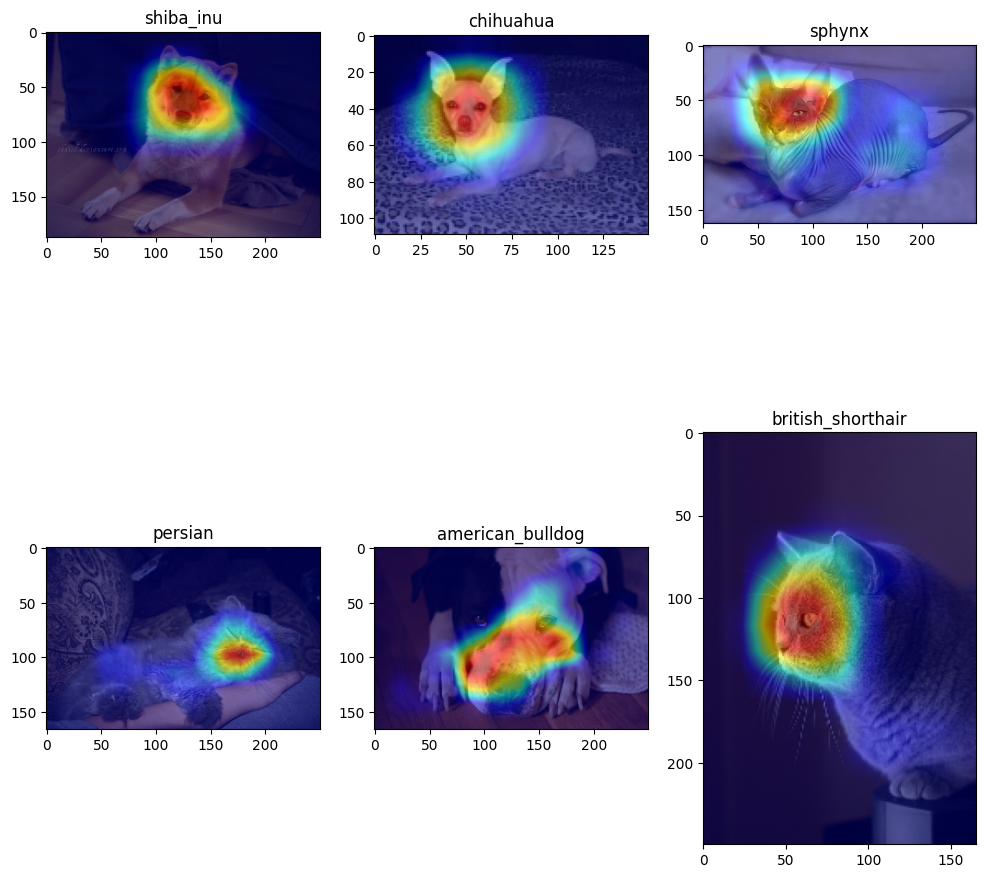

In [32]:
fig, axes = plt.subplots(2, 3, figsize = (12, 12))

target_layers = model_resnet.layer4[-1]

for i, class_ in enumerate(classes):
    image = list(df[df["form"] == class_]["path"])
    image = Image.open(image[0])
    img_tensor = transforms.ToTensor()(image)
    
    targets = [ClassifierOutputTarget(dict_num_class[class_])]

    axes[i//3][i%3].imshow(Image.fromarray(run_grad_cam_on_image(model=model_resnet,
                      target_layer=target_layers,
                      targets_for_gradcam=targets,
                      reshape_transform=None, input_tensor = img_tensor, input_image = image)), )
    axes[i//3][i%3].set_title(class_)

## Бинарная классификция

In [33]:
df_train, df_val = train_test_split(df, test_size = 0.15, stratify=df["family"])
print(df.shape)
print(df_train.shape)
print(df_val.shape)

train_data = DogCatDataset(df_train, target = "family", mode = "train")
val_data = DogCatDataset(df_val, target = "family", mode = "val")


train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 128)

(3686, 3)
(3133, 3)
(553, 3)


In [34]:
n_classes = 2

#for param in param_no_grad:
#    param.requires_grad = False

model_resnet.fc = nn.Linear(2048, n_classes, bias=True)

model_resnet.to(DEVICE)

optimizer = torch.optim.Adam(params=[
    {"params": model_resnet.fc.parameters()},
    {"params": model_resnet.conv1.parameters(), "lr": 1e-5 },
    {"params": model_resnet.avgpool.parameters(), "lr": 1e-5},
    {"params": model_resnet.bn1.parameters(), "lr": 1e-5},
    {"params": model_resnet.relu.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer1.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer2.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer3.parameters(), "lr": 1e-5},
    {"params": model_resnet.layer4.parameters(), "lr": 1e-5}
    ],
    lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model_resnet, loss_resnet, accuracy_resnet = train(model_resnet, train_loader, val_loader, epochs = 10, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001	 train_loss: 0.1292	     val_loss 0.0093	 train_acc 0.9585	 val_acc 1.0000

Epoch 002	 train_loss: 0.0133	     val_loss 0.0049	 train_acc 0.9968	 val_acc 0.9982

Epoch 003	 train_loss: 0.0067	     val_loss 0.0045	 train_acc 0.9981	 val_acc 0.9982

Epoch 004	 train_loss: 0.0063	     val_loss 0.0048	 train_acc 0.9984	 val_acc 0.9982

Epoch 005	 train_loss: 0.0043	     val_loss 0.0043	 train_acc 0.9987	 val_acc 0.9982

Epoch 006	 train_loss: 0.0043	     val_loss 0.0059	 train_acc 0.9997	 val_acc 0.9982

Epoch 007	 train_loss: 0.0024	     val_loss 0.0047	 train_acc 1.0000	 val_acc 0.9982

Epoch 008	 train_loss: 0.0040	     val_loss 0.0037	 train_acc 0.9990	 val_acc 0.9982

Epoch 009	 train_loss: 0.0037	     val_loss 0.0040	 train_acc 0.9990	 val_acc 0.9982

Epoch 010	 train_loss: 0.0026	     val_loss 0.0046	 train_acc 1.0000	 val_acc 0.9982
best val Acc: 1.000000
